# Plotting the Fraction of Dark Matter from Observational Datasets

## Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import h5py
import pandas as pd
import glob
from scipy import stats
from matplotlib.legend_handler import Line2D

def plot_median(ax, xdata, ydata, label, color):

    bins = np.arange(7, 14, 0.5)
    num_bins = len(bins)
    indx = np.digitize(xdata, bins)
    x_medians = np.array([np.median(xdata[indx == idx]) for idx in np.arange(num_bins) if len(xdata[indx == idx]) > 2])
    y_medians = np.array([np.median(ydata[indx == idx]) for idx in np.arange(num_bins) if len(xdata[indx == idx]) > 2])
    ylo = np.array([np.percentile(ydata[indx == idx],16) for idx in np.arange(num_bins) if len(xdata[indx == idx]) > 2])
    yhi = np.array([np.percentile(ydata[indx == idx],84) for idx in np.arange(num_bins) if len(xdata[indx == idx]) > 2])
    ax.plot(x_medians, y_medians, '-', lw=4, color='white')
    ax.plot(x_medians, y_medians, '-', lw=2, color=color, zorder=100)
    ax.fill_between(x_medians, yhi, ylo, color=color, alpha=0.2)


In [9]:
#################
# Plot parameters
params = {
    "font.size": 20,
    "font.family": "Arial Black",
    "text.usetex": True,
    "mathtext.fontset": "custom",
    "figure.figsize": (4, 3),
    "figure.subplot.left": 0.15,
    "figure.subplot.right": 0.95,
    "figure.subplot.bottom": 0.16,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.3,
    "figure.subplot.hspace": 0.3,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)
G = 6.67e-11
K = 1.65**2
kpc = 3.085e16*1e3
##################
# Halo Class
class classhalo:
    def __init__(self, file_path, type = 'all' ):
        self.file_path = file_path
        self.get_group_attributes(type)

    def get_group_attributes(self, type):
        with h5py.File(self.file_path, "r") as file:
            halo_data_group = file["Halo_data"]
            profile_data_group = file["Profile_data"]
            
            self.kappa = halo_data_group["kappa"][:]
            if type == 'disk':
                select = np.where(halo_data_group["kappa"][:] >= 0.3)[0]
            if type == 'elliptical':
                select = np.where(halo_data_group["kappa"][:] < 0.3)[0]
            if type == 'all':
                select = np.where(halo_data_group["kappa"][:] > 0)[0]
            

            # Halo_data attributes
            self.AxisRadius = halo_data_group["AxisRadius"][:]
            self.CrossSection = halo_data_group["CrossSection"][:, select]
            self.MeanCrossSection = halo_data_group["MeanCrossSection"][:, select]
            
            self.ReCrossSection = halo_data_group["ReCrossSection"][0, select]
            self.ReMeanCrossSection = halo_data_group["ReMeanCrossSection"][0, select]
            self.R12CrossSection = halo_data_group["R12CrossSection"][0, select]
            self.R12MeanCrossSection = halo_data_group["R12MeanCrossSection"][0, select]
            self.R200cCrossSection = halo_data_group["R200cCrossSection"][0, select]
            self.R200cMeanCrossSection = halo_data_group["R200cMeanCrossSection"][0, select]


            self.DynamicalRelaxation = halo_data_group["DynamicalRelaxation"][select]
            self.GalaxyHalfLightRadius = halo_data_group["GalaxyHalfLightRadius"][select]
            self.GalaxyHalfMassRadius = halo_data_group["GalaxyHalfMassRadius"][select]
            self.GalaxyLuminosity = halo_data_group["GalaxyLuminosity"][select]
            self.GalaxyProjectedHalfLightRadius = halo_data_group["GalaxyProjectedHalfLightRadius"][select]
            self.GalaxyProjectedHalfMassRadius = halo_data_group["GalaxyProjectedHalfMassRadius"][select]
            self.ID = halo_data_group["ID"][select]
            self.M200c = halo_data_group["M200c"][select]
            self.Mgas = halo_data_group["Mgas"][select]
            self.Mstar = halo_data_group["Mstar"][select]
            self.R200c = halo_data_group["R200c"][select]
            self.SpecificAngularMomentum = halo_data_group["SpecificAngularMomentum"][select,:]
            self.StructureType = halo_data_group["StructureType"][select]
            self.Vmax = halo_data_group["Vmax"][select]
            self.c200c = halo_data_group["c200c"][select]

            sarg =0

            # Profile_data attributes
            self.Circular_Velocity = profile_data_group["Circular_Velocity"][:, select]
            self.Dark_matter_Circular_Velocity = profile_data_group["Dark_matter_Circular_Velocity"][:, select]
            self.Dark_matter_Density_profile = profile_data_group["Dark_matter_Density_profile"][sarg:,select]
            self.Dark_matter_Sigma_profile = profile_data_group["Dark_matter_Sigma_profile"][sarg:,select]
            self.Dark_matter_Velocity_dispersion = profile_data_group["Dark_matter_Velocity_dispersion"][sarg:,select]
            self.Density_profile = profile_data_group["Density_profile"][sarg:,select]
            self.Density_radial_bins = profile_data_group["Density_radial_bins"][sarg:]
            self.Gas_Circular_Velocity = profile_data_group["Gas_Circular_Velocity"][:,select]
            self.Gas_Density_profile = profile_data_group["Gas_Density_profile"][sarg:,select]
            self.Gas_Velocity_dispersion = profile_data_group["Gas_Velocity_dispersion"][sarg:,select]
            self.Stars_Circular_Velocity = profile_data_group["Stars_Circular_Velocity"][:,select]
            self.Stars_Density_profile = profile_data_group["Stars_Density_profile"][sarg:,select]
            self.Stars_Velocity_dispersion = profile_data_group["Stars_Velocity_dispersion"][sarg:,select]
            self.Velocity_radial_bins = profile_data_group["Velocity_radial_bins"][:]
            self.Projected_fDM = halo_data_group["GalaxyProjectedDarkMatterFraction"][:, select]
            self.fDM = halo_data_group["GalaxyDarkMatterFraction"][:, select]
            self.theo_fDM = halo_data_group["GalaxyTheoricalDarkMatterFraction"][:, select]

            self.fDM_cal= (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2






       
        
file_paths = ['Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep30Anisotropic.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep60Anisotropic.hdf5',
              'Halo_data_L025N376ReferenceSigmaConstant00.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep60Anisotropic.hdf5']

file_names = ['WeakStellarFB', 'WeakStellarFB', 'WeakStellarFB', 'Reference', 'Reference', 'Reference']
titles = ['CDM', 'SigmaVel30', 'SigmaVel60', 'CDM', 'SigmaVel30', 'SigmaVel60'] # Minor changes



In [2]:
sparc = pd.read_csv('../Observational_datasets/dataset/SPARC.csv').to_numpy()
atlas3D = pd.read_csv('../Observational_datasets/dataset/ATLAS3D.csv').to_numpy()
banarbe = pd.read_csv('../Observational_datasets/dataset/BARNABE11.csv').to_numpy()
manga = pd.read_csv('../Observational_datasets/dataset/MANGA.csv').to_numpy()
reyes = pd.read_csv('../Observational_datasets/dataset/Reyes2011.csv').to_numpy()
pizagno = pd.read_csv('../Observational_datasets/dataset/Pizagno2007.csv').to_numpy()
tortora = pd.read_csv('../Observational_datasets/dataset/TORTORA12.csv').to_numpy()


sparc_mass = sparc[:,1]
sparc_Reff = sparc[:,2]
sparc_fDM = sparc[:,3]
sparc_ErrorfDM = sparc[:,4]
Q = sparc[:,5]
select = np.where(Q==1)[0]
sparc_mass = sparc_mass[select]
sparc_fDM = sparc_fDM[select]
sparc_ErrorfDM = sparc_ErrorfDM[select]
sparc_Reff = sparc_Reff[select]


manga_mass = manga[:,2]
manga_fDM = manga[:,4]
manga_Reff= manga[:,3]

select = np.where(manga_fDM>0)[0]

manga_mass = manga_mass[select]
manga_fDM = manga_fDM[select]
manga_Reff = manga_Reff[select]

atlas3D_mass = atlas3D[:,1]
atlas3D_fDM = atlas3D[:,3]
atlas3D_Reff = atlas3D[:,2]
Q = atlas3D[:,5]
select = np.where((Q>=3) & (atlas3D_fDM>0))[0]
atlas3D_mass = atlas3D_mass[select]
atlas3D_fDM = atlas3D_fDM[select]
atlas3D_Reff = atlas3D_Reff[select]


barnabe_mass = banarbe[:,1]
barnabe_fDM = banarbe[:,2]
barnabe_Reff = banarbe[:,-1]

tortora_mass = tortora[:,0]
tortora_fDM = tortora[:,1]

reyes_mass = reyes[:,1]
reyes_Reff = reyes[:,2]
reyes_fDM = reyes[:,3]

pizagno_mass = pizagno[:,1]
pizagno_Reff = pizagno[:,2]
pizagno_fDM = pizagno[:,3]


In [3]:
Mpi=[]
for mass in pizagno_mass:
    Mpi.append(mass)
    
Mre= []    
for mass in reyes_mass:
    Mre.append(mass)

Msp=[]
for mass in sparc_mass:
    Msp.append(mass)


Mtot=np.array([])
Mtot=np.append(Mtot,np.log10(Mpi))
Mtot= np.append(Mtot,np.log10(Mre))
Mtot= np.append(Mtot,np.log10(Msp))
ftot = []
ftot=np.append(ftot,pizagno_fDM)
ftot=np.append(ftot,reyes_fDM)
ftot=np.append(ftot,sparc_fDM)
rtot = np.array([])
rtot= np.append(rtot,pizagno_Reff)
rtot = np.append(rtot, reyes_Reff)
rtot = np.append(rtot, sparc_Reff)



## Plotting the median for dark matter fraction for both observational samples and simulation data

/tmp/ipykernel_41222/597234568.py:93: RuntimeWarning: invalid value encountered in divide
  self.fDM_cal= (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2


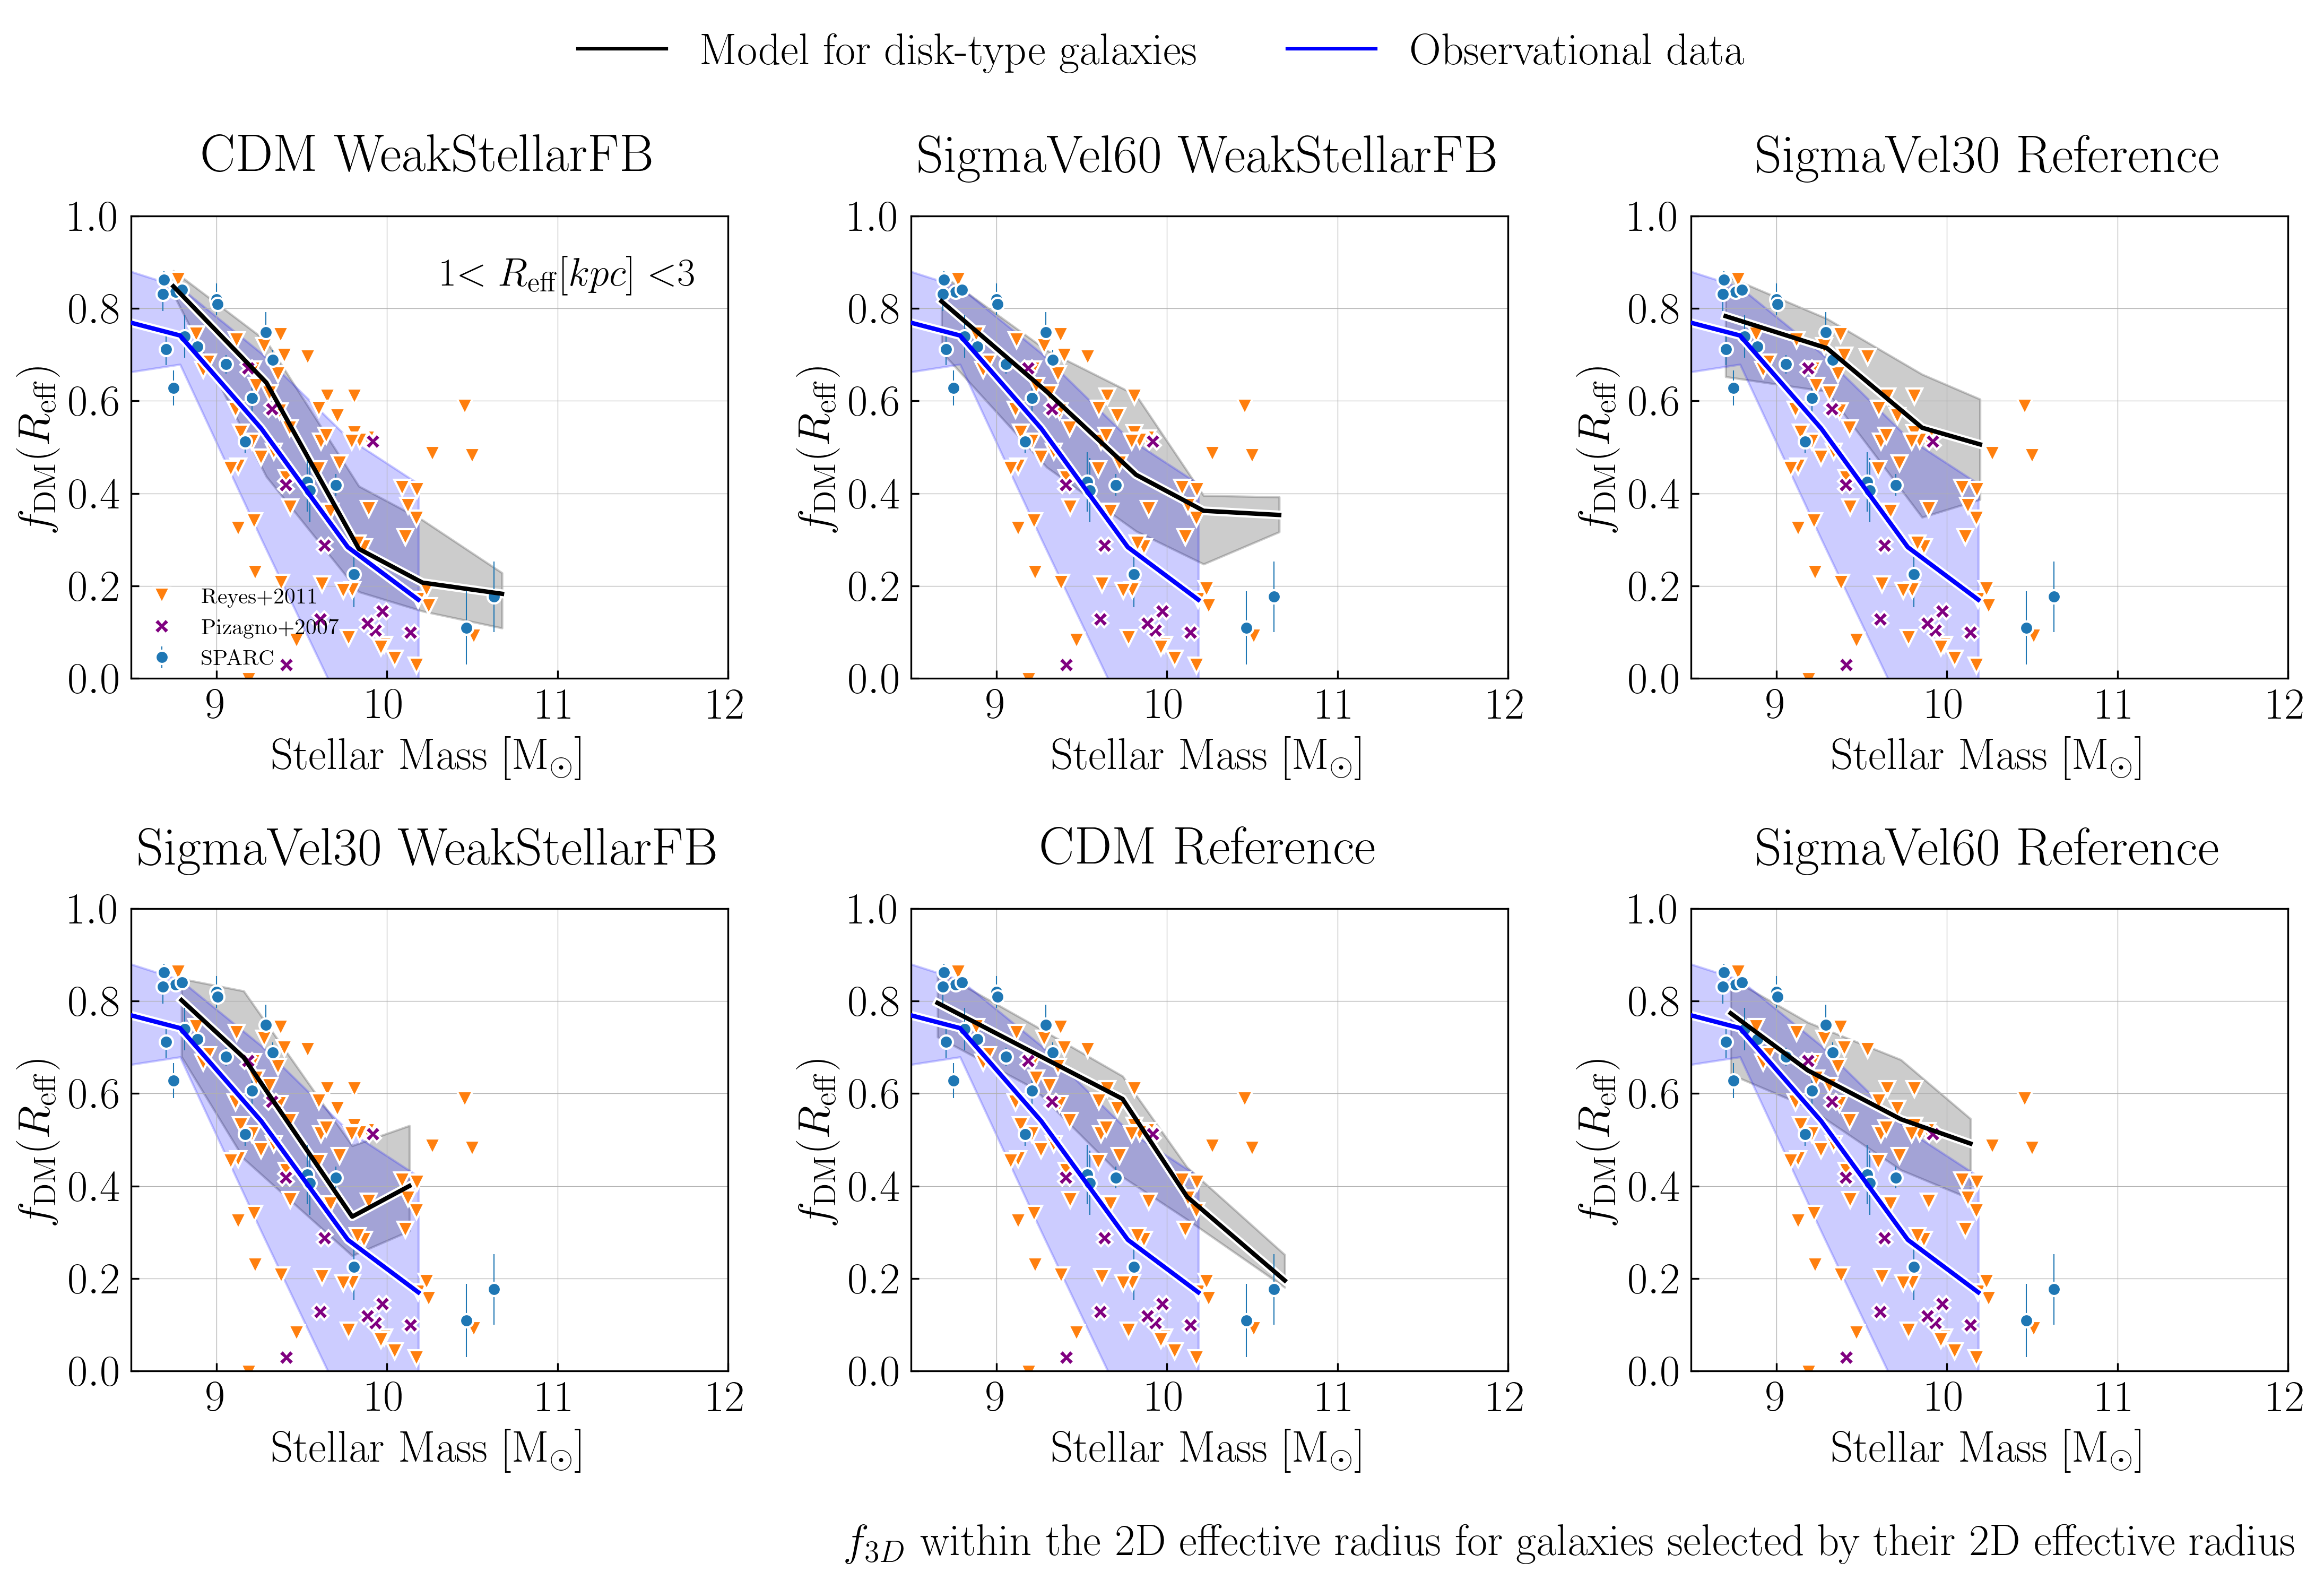

/tmp/ipykernel_41222/597234568.py:93: RuntimeWarning: invalid value encountered in divide
  self.fDM_cal= (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2


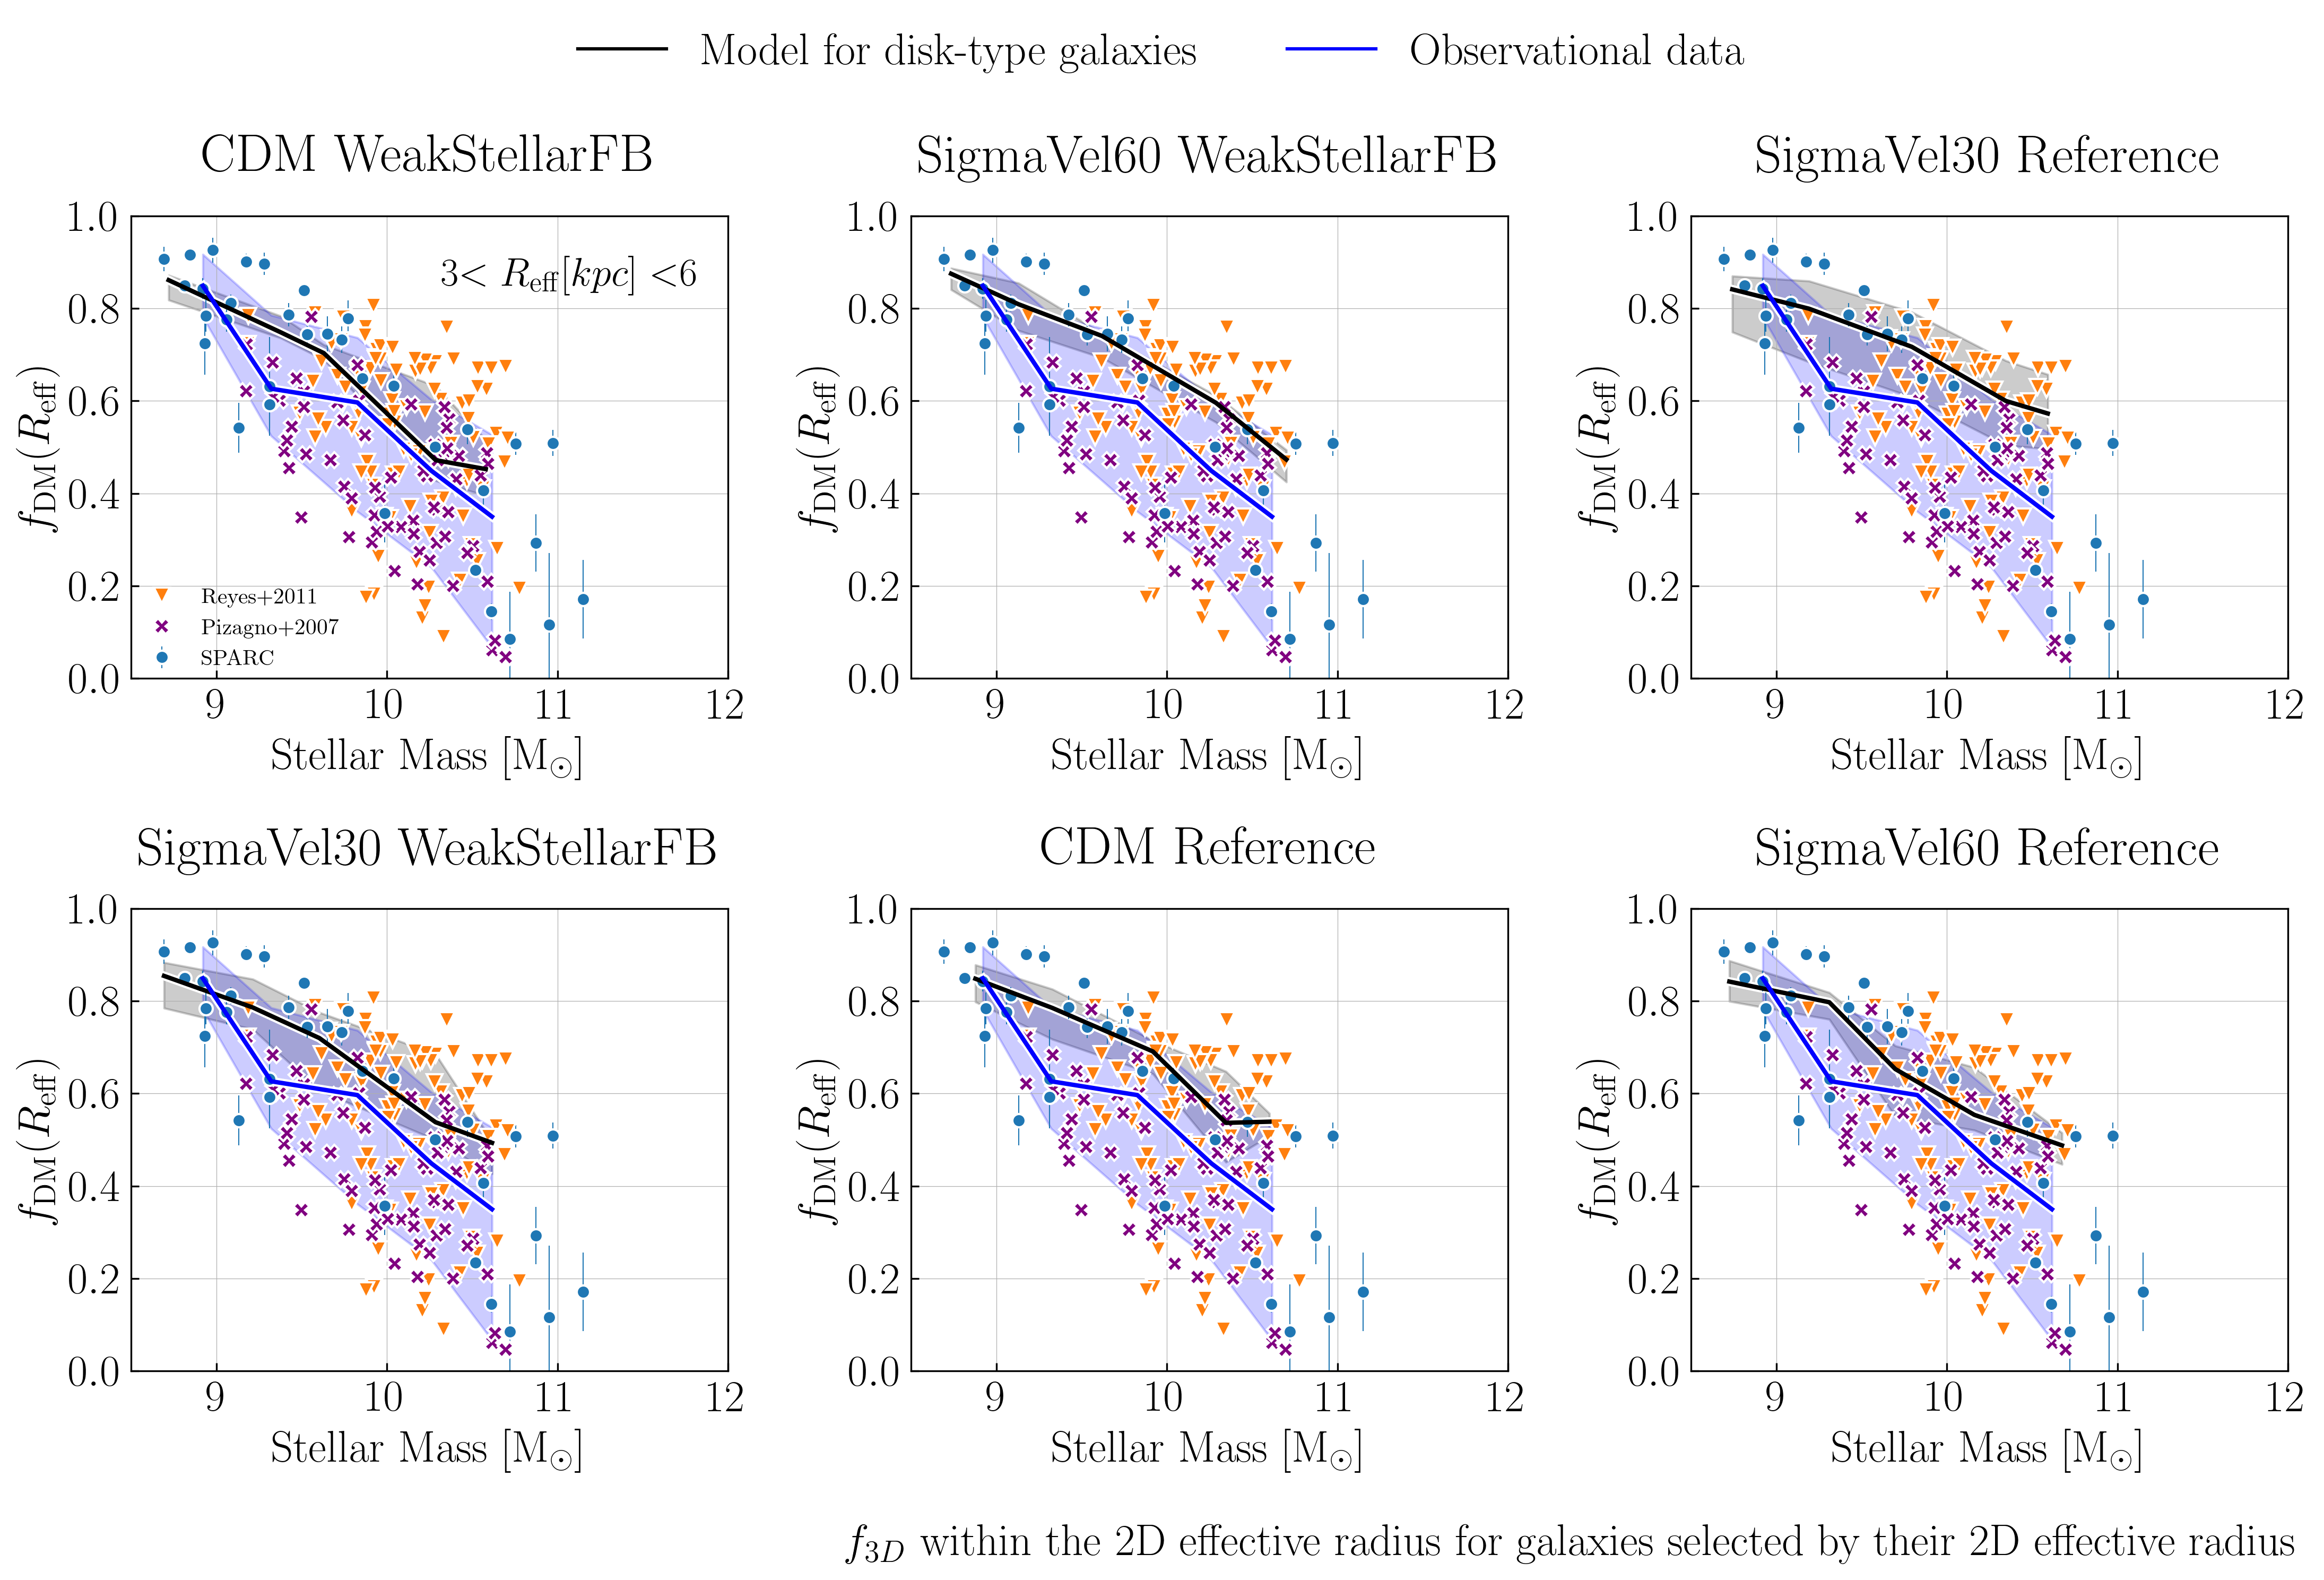

In [11]:
ranges = [(1, 3), (3, 6)]


#fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=300) # Increasing resolution (minimum dpi=300 always)

for range_idx, (min_val, max_val) in enumerate(ranges):
    fig, axs = plt.subplots(2, 3, figsize=(15, 9), dpi=300)
    
    select = (rtot < max_val) & (rtot > min_val)
    selectsp = (sparc_Reff < max_val) & (sparc_Reff > min_val)
    selectre = (reyes_Reff < max_val) & (reyes_Reff > min_val)
    selectpi = (pizagno_Reff < max_val) & (pizagno_Reff > min_val)

    for j, file_path in enumerate(file_paths):
        cols = j//2
        lin = j%2
        ax = axs[lin, cols]

        ax.set_xlabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')
        ax.set_ylabel(r'$f_{\mathrm{DM}}(R_{\mathrm{eff}})$')

        ax.set_xlim([8.5, 12])
        ax.set_ylim([0,1])
        ax.grid(linestyle='-', linewidth=0.3)
        ax.set_title(titles[j] + ' ' + file_names[j], pad = 20)

        halo = classhalo('../Simulation_datasets/TangoSIDM/'+file_path, type='disk')

        M = halo.Mstar
        fDM = halo.fDM
        f = []
        for k in range(len(fDM[0, :])):
            f.append(np.interp(halo.GalaxyProjectedHalfLightRadius[k], halo.AxisRadius, fDM[:, k]))

        selecttango = (halo.GalaxyProjectedHalfLightRadius > min_val) & (halo.GalaxyProjectedHalfLightRadius < max_val)

        plot_median(ax, M[selecttango], np.array(f)[selecttango], 'TangoSIDM','black')
        #ax.scatter(M[selecttango], np.array(f)[selecttango], c='black', s = 50)
        
        ax.errorbar(np.log10(Msp)[selectsp], sparc_fDM[selectsp], yerr=sparc_ErrorfDM[selectsp], marker='o', markersize=6, 
                     markeredgecolor="white", ls='none', lw=0.5, c='tab:blue',label='SPARC')

        ax.plot(np.log10(Mre)[selectre], reyes_fDM[selectre], 'v', ms=7, color='tab:orange',markeredgecolor='white',lw=0.1,label='Reyes+2011')

        ax.plot(np.log10(Mpi)[selectpi], pizagno_fDM[selectpi], 'X', ms=7, color='purple',markeredgecolor='white',lw=0.1,label='Pizagno+2007')
        
        plot_median(ax, np.array(Mtot)[select], np.array(ftot)[select], 'Spiral', 'blue')
            
        ax.tick_params(direction='in', axis='both', which='both', pad=4.5) # Minor thing
        if j == 0:
            ax.legend(loc='lower left', ncol=1, borderaxespad=0.00000001, framealpha=0, fontsize = 10)
            ax.text(0.95,0.85, str(min_val)+r'$<R_{\mathrm{eff}} [kpc]< $'+str(max_val), fontsize=18, ha='right', transform=ax.transAxes)
    
    handles = [Line2D([], [], linestyle='-', color = 'black'),
               Line2D([], [], linestyle='-', color = 'blue')]

    fig.legend(handles, ['Model for disk-type galaxies', 'Observational data'], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, borderaxespad=0.00000001, framealpha=0)

    plt.tight_layout()
    plt.text(-0.2,-0.4, r'$f_{3D}$ within the 2D effective radius for galaxies selected by their 2D effective radius', ha = 'center', transform=plt.gca().transAxes)
    plt.show()


/tmp/ipykernel_41222/597234568.py:93: RuntimeWarning: invalid value encountered in divide
  self.fDM_cal= (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2


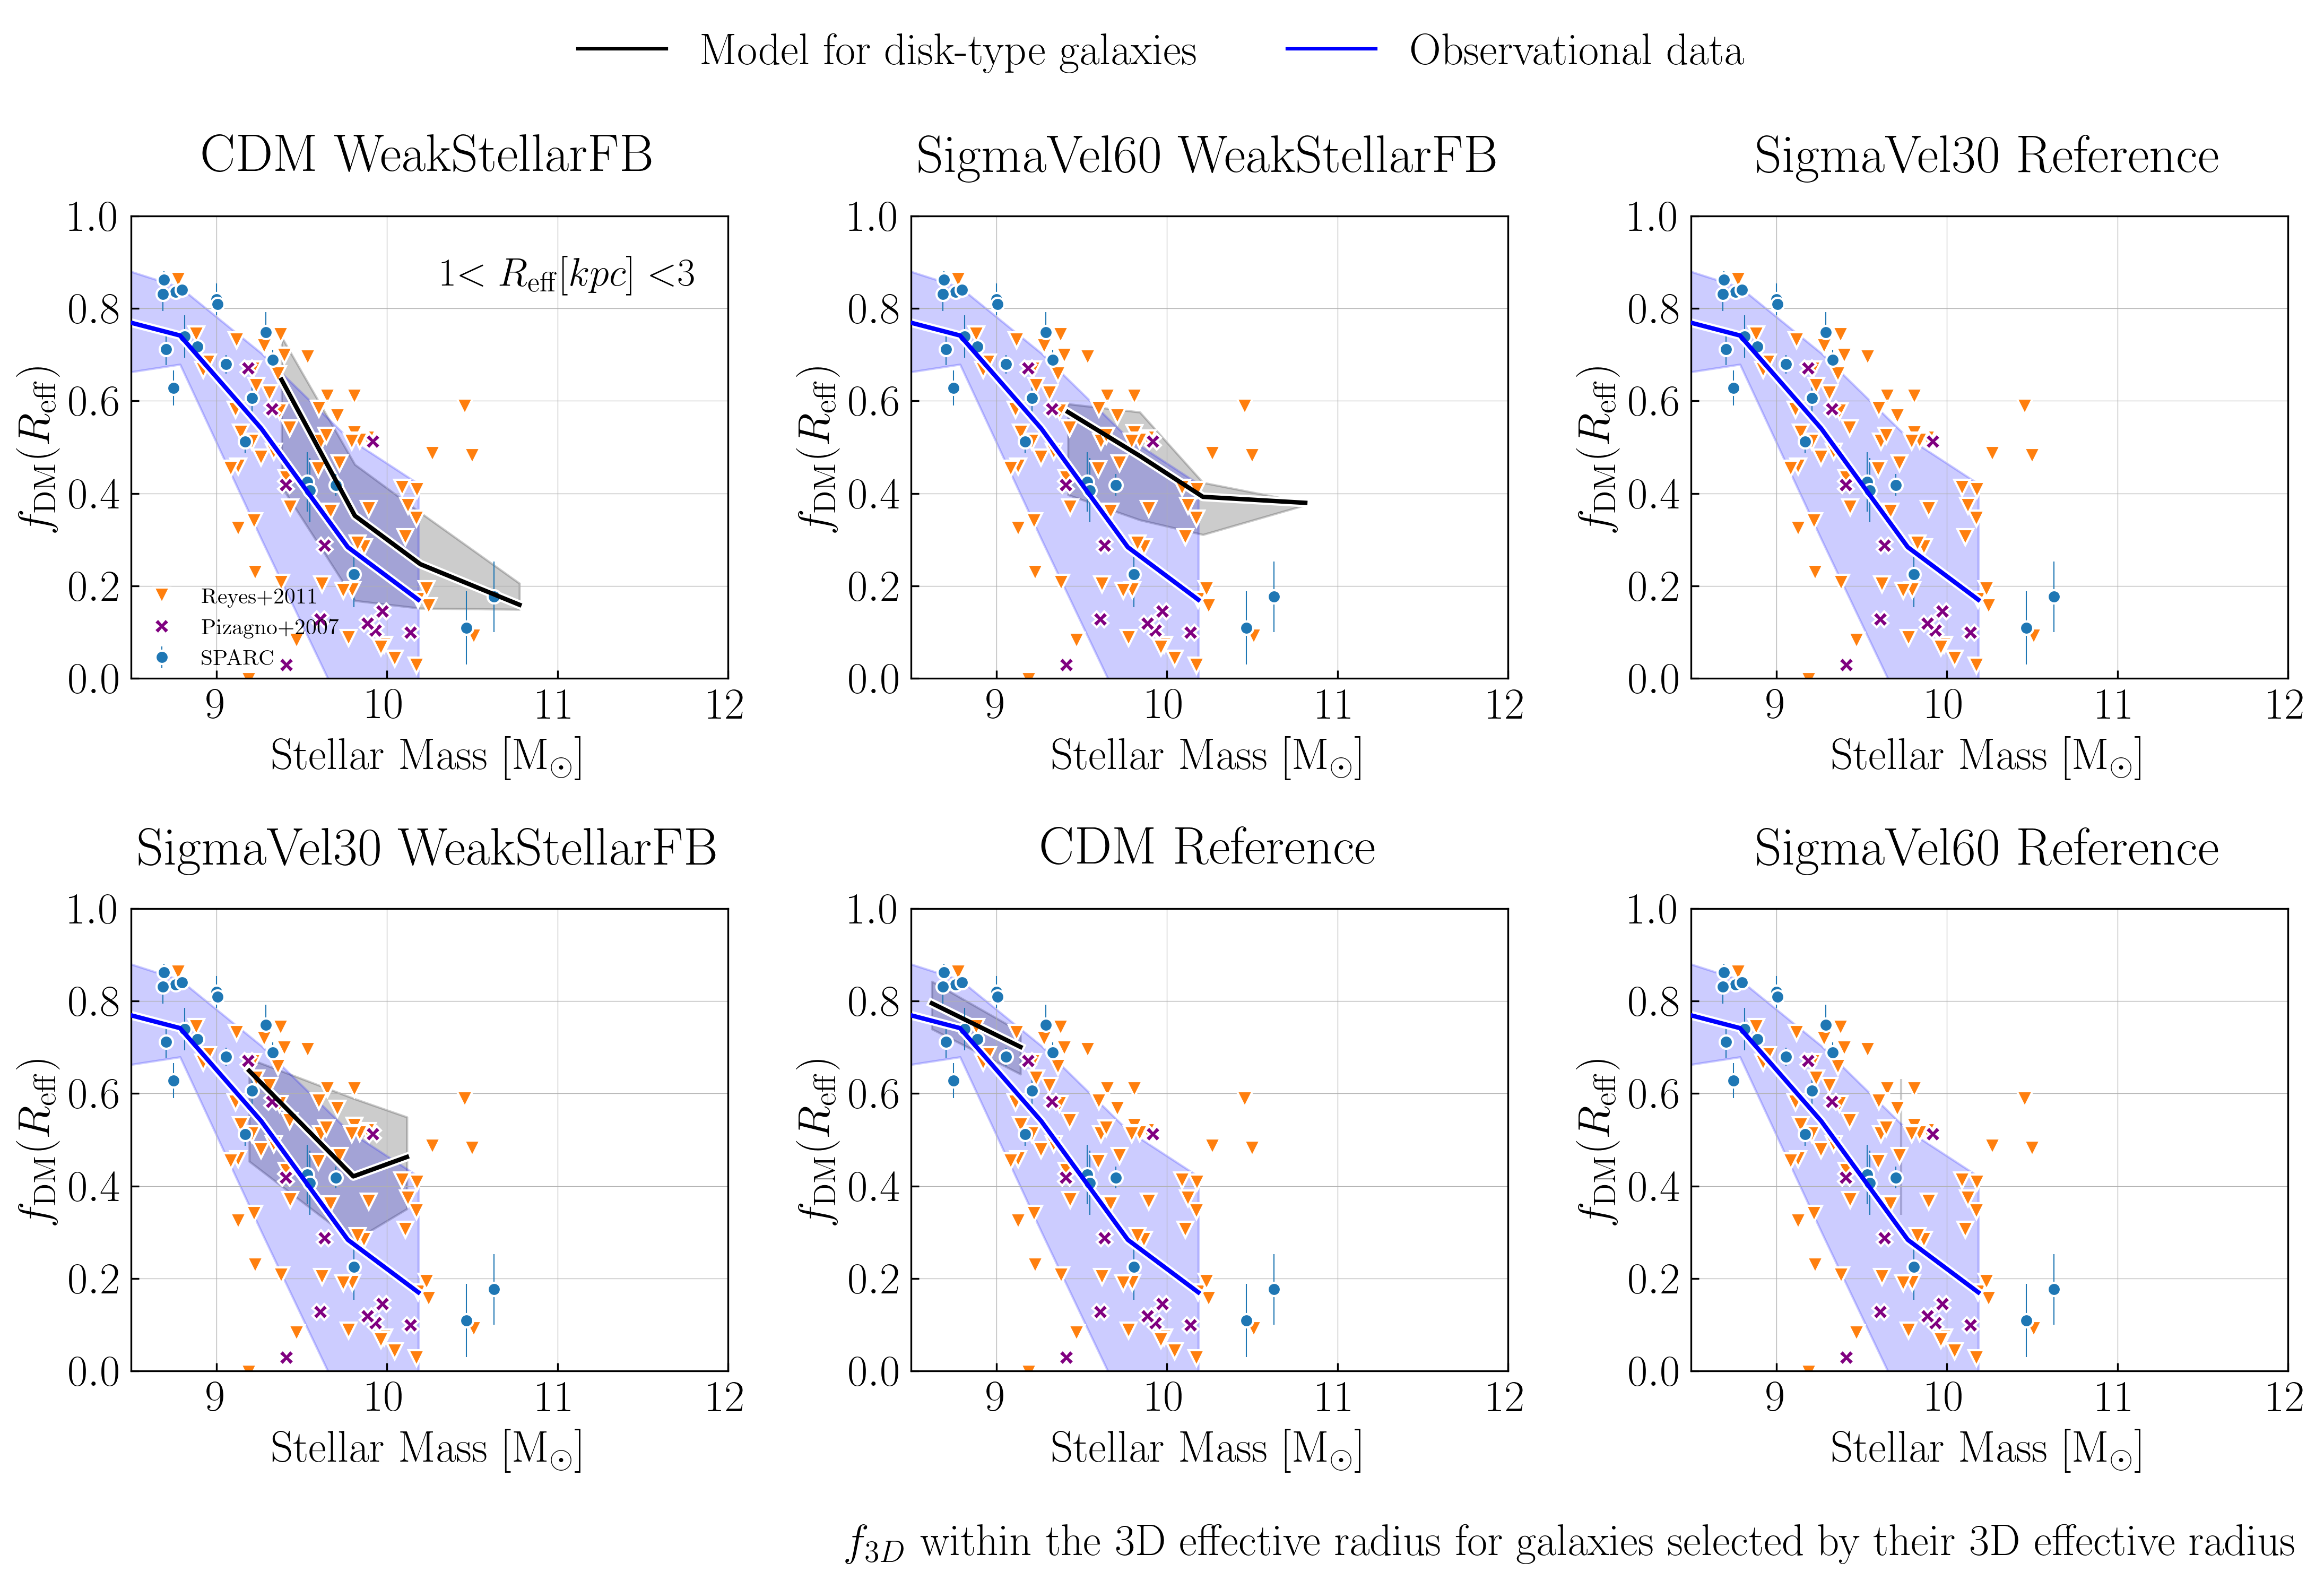

/tmp/ipykernel_41222/597234568.py:93: RuntimeWarning: invalid value encountered in divide
  self.fDM_cal= (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2


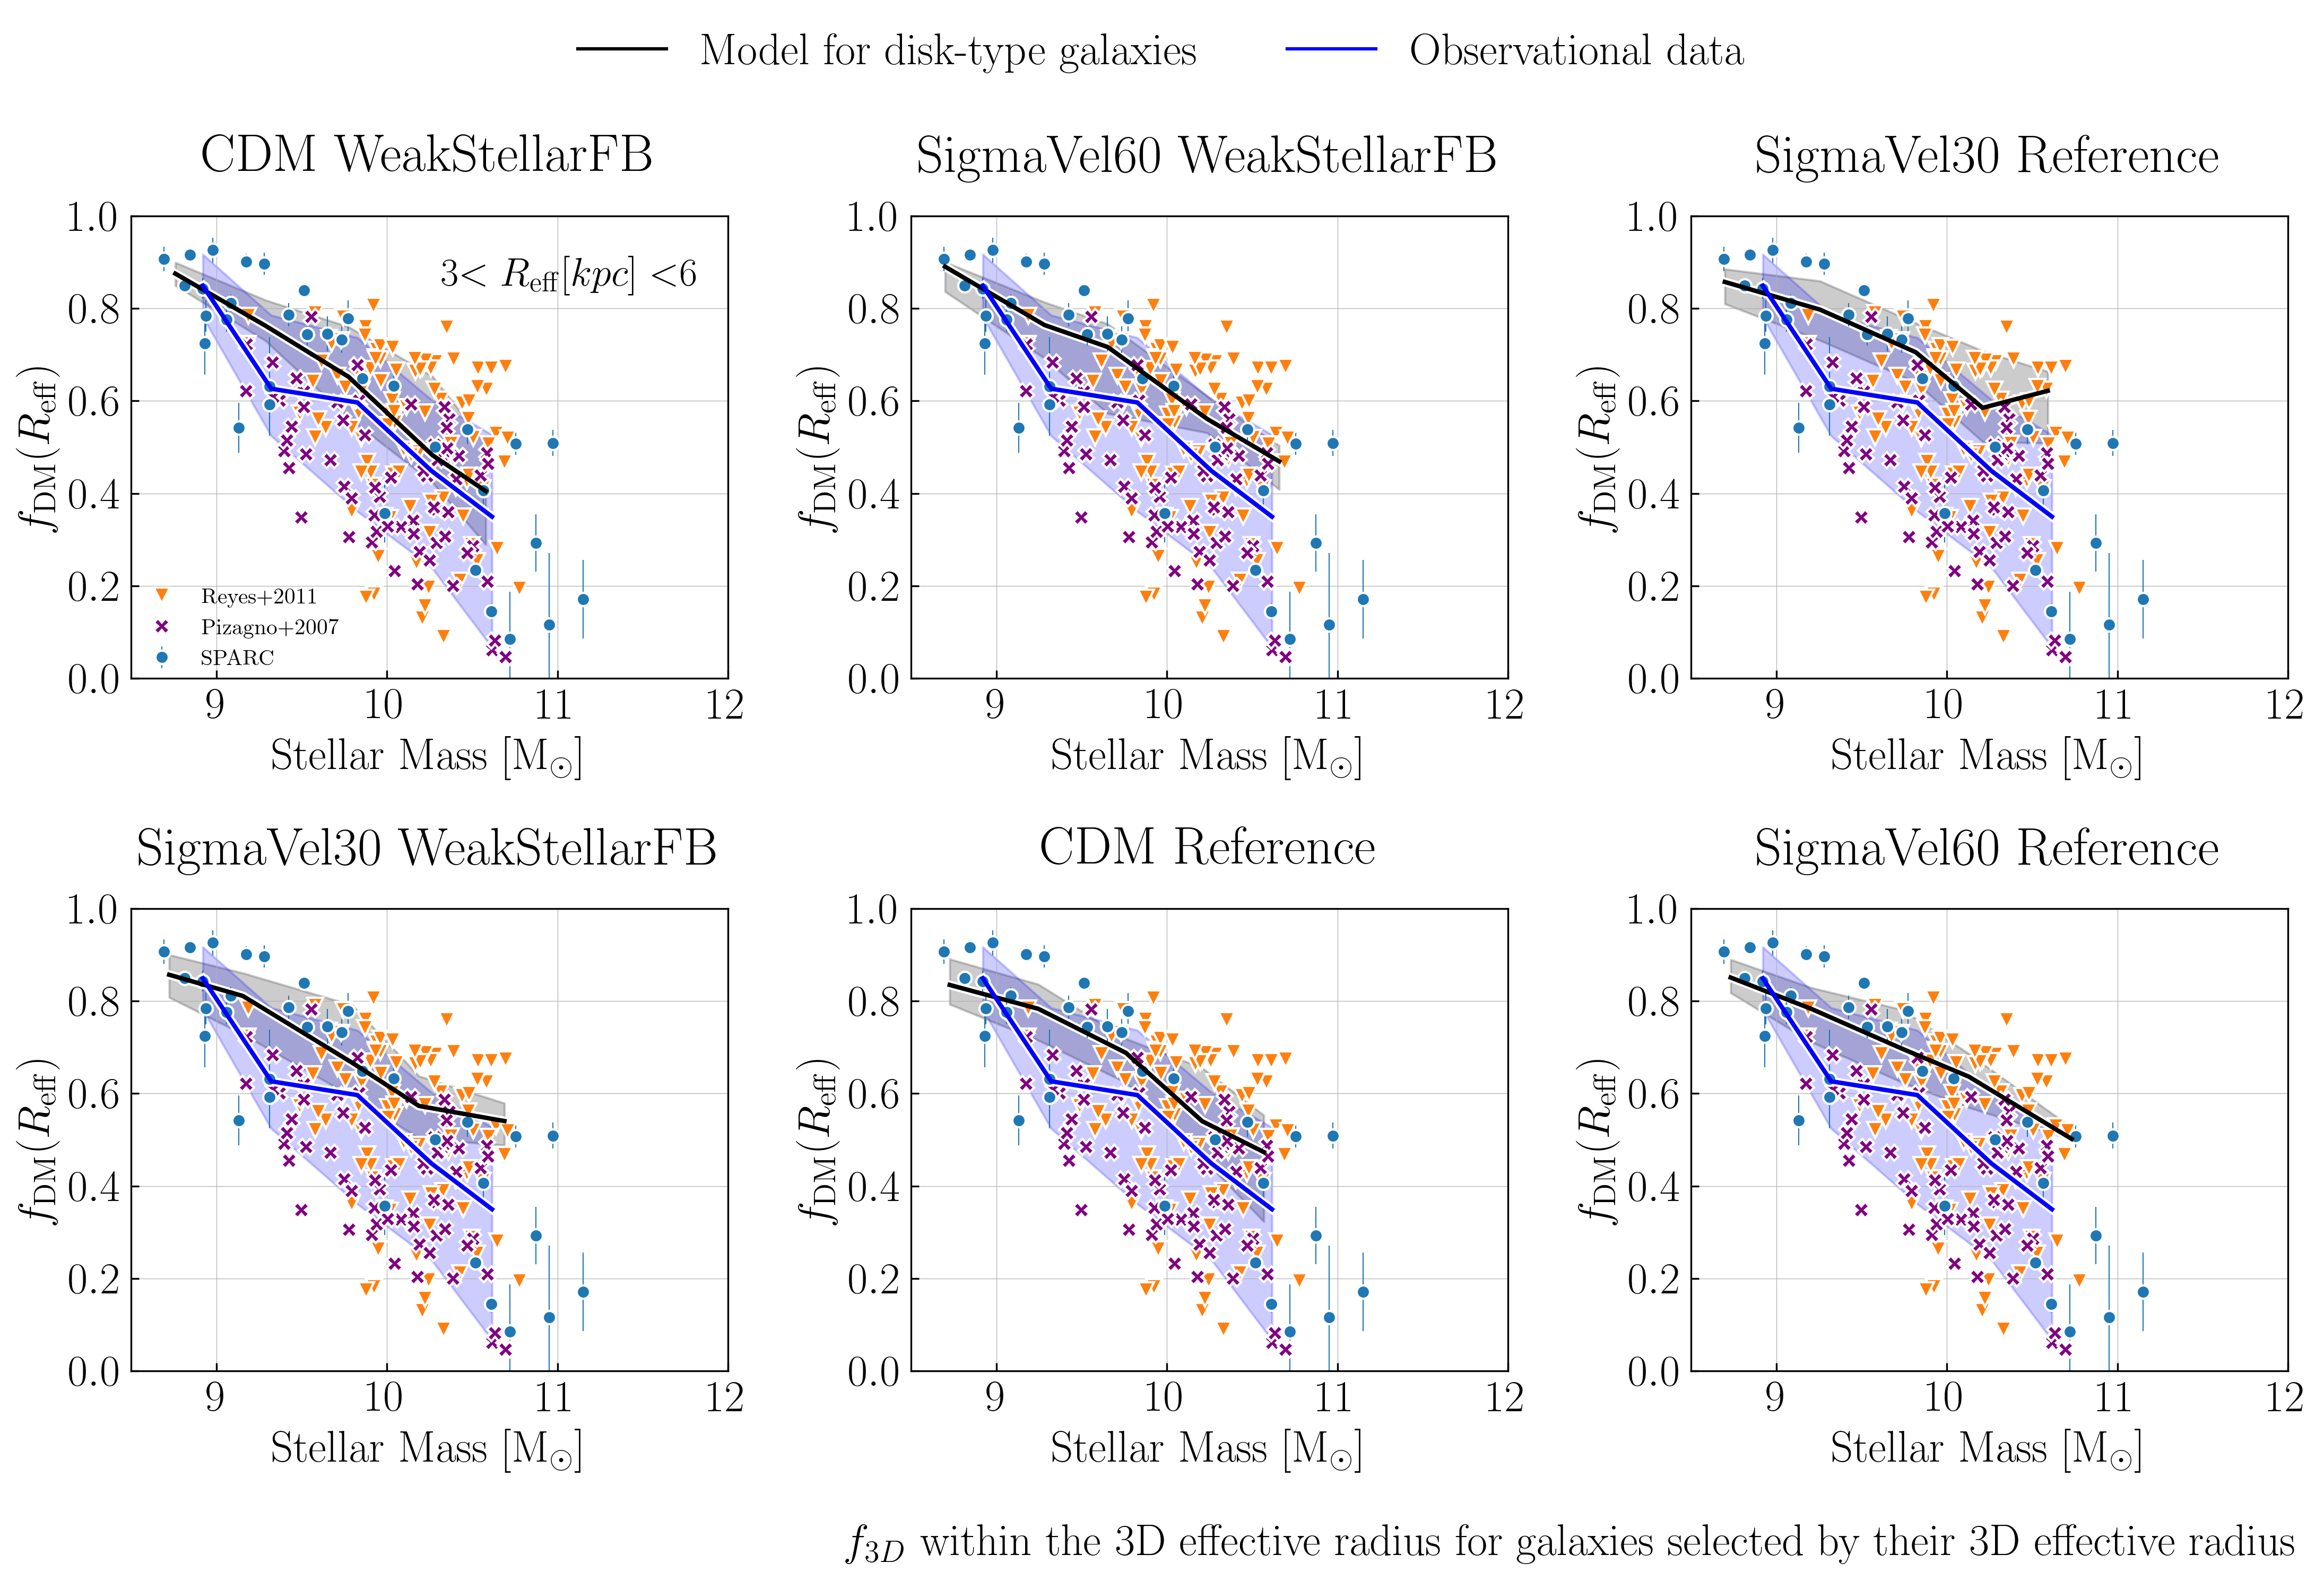

In [13]:
ranges = [(1, 3), (3, 6)]


#fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=300) # Increasing resolution (minimum dpi=300 always)

for range_idx, (min_val, max_val) in enumerate(ranges):
    fig, axs = plt.subplots(2, 3, figsize=(15, 9), dpi=300)
    
    select = (rtot < max_val) & (rtot > min_val)
    selectsp = (sparc_Reff < max_val) & (sparc_Reff > min_val)
    selectre = (reyes_Reff < max_val) & (reyes_Reff > min_val)
    selectpi = (pizagno_Reff < max_val) & (pizagno_Reff > min_val)

    for j, file_path in enumerate(file_paths):
        cols = j//2
        lin = j%2
        ax = axs[lin, cols]

        ax.set_xlabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')
        ax.set_ylabel(r'$f_{\mathrm{DM}}(R_{\mathrm{eff}})$')

        ax.set_xlim([8.5, 12])
        ax.set_ylim([0,1])
        ax.grid(linestyle='-', linewidth=0.3)
        ax.set_title(titles[j] + ' ' + file_names[j], pad = 20)

        halo = classhalo('../Simulation_datasets/TangoSIDM/'+file_path, type='disk')

        M = halo.Mstar
        fDM = halo.fDM
        f = []
        for k in range(len(fDM[0, :])):
            f.append(np.interp(halo.GalaxyHalfLightRadius[k], halo.AxisRadius, fDM[:, k]))

        selecttango = (halo.GalaxyHalfLightRadius > min_val) & (halo.GalaxyHalfLightRadius < max_val)

        plot_median(ax, M[selecttango], np.array(f)[selecttango], 'TangoSIDM','black')
        #ax.scatter(M[selecttango], np.array(f)[selecttango], c='black', s = 50)
        
        ax.errorbar(np.log10(Msp)[selectsp], sparc_fDM[selectsp], yerr=sparc_ErrorfDM[selectsp], marker='o', markersize=6, 
                     markeredgecolor="white", ls='none', lw=0.5, c='tab:blue',label='SPARC')

        ax.plot(np.log10(Mre)[selectre], reyes_fDM[selectre], 'v', ms=7, color='tab:orange',markeredgecolor='white',lw=0.1,label='Reyes+2011')

        ax.plot(np.log10(Mpi)[selectpi], pizagno_fDM[selectpi], 'X', ms=7, color='purple',markeredgecolor='white',lw=0.1,label='Pizagno+2007')
        
        plot_median(ax, np.array(Mtot)[select], np.array(ftot)[select], 'Spiral', 'blue')
            
        ax.tick_params(direction='in', axis='both', which='both', pad=4.5) # Minor thing
        if j == 0:
            ax.legend(loc='lower left', ncol=1, borderaxespad=0.00000001, framealpha=0, fontsize = 10)
            ax.text(0.95,0.85, str(min_val)+r'$<R_{\mathrm{eff}} [kpc]< $'+str(max_val), fontsize=18, ha='right', transform=ax.transAxes)
    
    handles = [Line2D([], [], linestyle='-', color = 'black'),
               Line2D([], [], linestyle='-', color = 'blue')]

    fig.legend(handles, ['Model for disk-type galaxies', 'Observational data'], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, borderaxespad=0.00000001, framealpha=0)

    plt.tight_layout()
    plt.text(-0.2,-0.4, r'$f_{3D}$ within the 3D effective radius for galaxies selected by their 3D effective radius', ha = 'center', transform=plt.gca().transAxes)
    plt.show()


Text(0.5, 0, '$\\log_{10}M_{*} [\\mathrm{M}_{\\odot}]$')

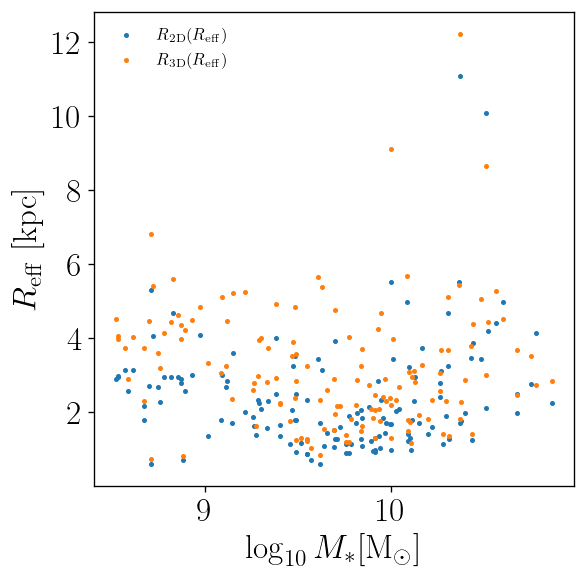

In [24]:
halo = classhalo('../Simulation_datasets/TangoSIDM/'+'Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5', "disk")
plt.figure(dpi = 120, figsize = (5,5))
plt.scatter(halo.Mstar,halo.GalaxyProjectedHalfLightRadius, label = r'$R_{\mathrm{2D}}$($R_{\mathrm{eff}}$)')
plt.scatter(halo.Mstar,halo.GalaxyHalfLightRadius, label = r'$R_{\mathrm{3D}}$($R_{\mathrm{eff}}$)')
plt.legend(loc='upper left', ncol=1, framealpha=0, fontsize = 10)
plt.ylabel(r'$R_{\mathrm{eff}}$ [kpc]')
plt.xlabel(r'$\log_{10}M_{*} [\mathrm{M}_{\odot}]$')
